### Notebook for reconstructing networks and analyzing their properties

### Import necessary packages

In [1]:
%matplotlib notebook
#%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import re
import io
import os
import sys 
sys.path.append('..')
from brian2 import *
import brian_utils.postproc as bup
import pickle
import math
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from statsmodels.formula.api import *
from statsmodels import *
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load data

In [2]:
lm_df = pd.read_csv('gnap_mod_network_data.csv')
lm_df.head()

,Unnamed: 0,run_seed,num_exc,num_inh,num_e_e,num_e_i,num_i_e,num_i_i,ctrl_mean_period,ctrl_mean_amp,...,num_gnap05_burst_exc,num_gnap05_tonic_inh,num_gnap05_quiescent_inh,num_gnap05_burst_inh,num_damgo_gnap05_tonic_exc,num_damgo_gnap05_quiescent_exc,num_damgo_gnap05_burst_exc,num_damgo_gnap05_tonic_inh,num_damgo_gnap05_quiescent_inh,num_damgo_gnap05_burst_inh
0,0,1,754.0,162.0,622.0,132.0,122.0,40.0,3.111741,3.920873,...,403.0,62.0,0.0,100.0,3.0,243.0,508.0,0.0,66.0,96.0
1,1,2,714.0,173.0,585.0,129.0,145.0,28.0,3.365985,2.962704,...,375.0,82.0,2.0,89.0,13.0,202.0,499.0,7.0,49.0,117.0
2,2,3,767.0,172.0,607.0,160.0,136.0,36.0,3.018855,4.157768,...,427.0,70.0,0.0,102.0,2.0,276.0,489.0,1.0,68.0,103.0
3,3,4,714.0,192.0,581.0,133.0,159.0,33.0,3.172900,3.845124,...,382.0,100.0,0.0,92.0,12.0,228.0,474.0,1.0,56.0,135.0
4,4,5,728.0,182.0,583.0,145.0,145.0,37.0,2.661788,3.363617,...,364.0,86.0,1.0,95.0,20.0,225.0,483.0,5.0,63.0,114.0


### PCA

In [3]:
from pca import pca
features = ['num_e_e','num_e_i','num_i_e','num_i_i', 
            'num_ctrl_tonic_exc', 'num_ctrl_tonic_inh',
            'num_ctrl_burst_exc', 'num_ctrl_burst_inh',
            'num_ctrl_quiescent_exc', 'num_ctrl_quiescent_inh',
            'num_damgo_tonic_exc', 'num_damgo_tonic_inh',
            'num_damgo_burst_exc', 'num_damgo_burst_inh',
            'num_damgo_quiescent_exc', 'num_damgo_quiescent_inh',
            'num_gnap01_tonic_exc', 'num_gnap01_tonic_inh',
            'num_gnap01_burst_exc', 'num_gnap01_burst_inh',
            'num_gnap01_quiescent_exc', 'num_gnap01_quiescent_inh',
            'num_gnap03_tonic_exc', 'num_gnap03_tonic_inh',
            'num_gnap03_burst_exc', 'num_gnap03_burst_inh',
            'num_gnap03_quiescent_exc', 'num_gnap03_quiescent_inh',
            'num_gnap05_tonic_exc', 'num_gnap05_tonic_inh',
            'num_gnap05_burst_exc', 'num_gnap05_burst_inh',
            'num_gnap05_quiescent_exc', 'num_gnap05_quiescent_inh',
            'num_damgo_gnap01_tonic_exc', 'num_damgo_gnap01_tonic_inh',
            'num_damgo_gnap01_burst_exc', 'num_damgo_gnap01_burst_inh',
            'num_damgo_gnap01_quiescent_exc', 'num_damgo_gnap01_quiescent_inh',
            'num_damgo_gnap03_tonic_exc', 'num_damgo_gnap03_tonic_inh',
            'num_damgo_gnap03_burst_exc', 'num_damgo_gnap03_burst_inh',
            'num_damgo_gnap03_quiescent_exc', 'num_damgo_gnap03_quiescent_inh',
            'num_damgo_gnap05_tonic_exc', 'num_damgo_gnap05_tonic_inh',
            'num_damgo_gnap05_burst_exc', 'num_damgo_gnap05_burst_inh',
            'num_damgo_gnap05_quiescent_exc', 'num_damgo_gnap05_quiescent_inh',]
X = lm_df.loc[:, features].values
#X = preprocessing.StandardScaler().fit_transform(X)
pca = PCA(n_components=40)
model = pca.fit_transform(X)
pve = pca.explained_variance_ratio_
np.sum(pve[0:8])

0.9514899448971379

Text(0, 0.5, 'Cumulative Proportion\n of Variance Explained (%)')

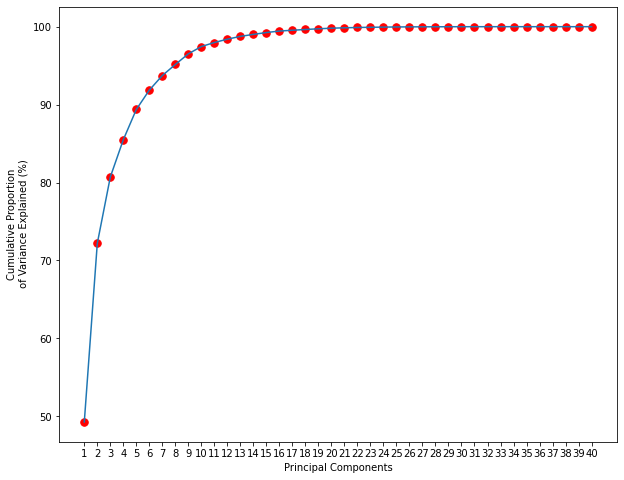

In [4]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1,41,1), np.cumsum(pca.explained_variance_ratio_)*100,'.',color='r',markersize=15)
plt.plot(np.arange(1,41,1), np.cumsum(pca.explained_variance_ratio_)*100)
plt.xticks(np.arange(1,41,1))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Proportion\n of Variance Explained (%)')

In [5]:
pca.components_

array([[-0.19566888,  0.00304823,  0.10092347, ...,  0.03985067,
         0.15427748,  0.08479974],
       [-0.28904554, -0.07861171, -0.03753084, ..., -0.02695105,
        -0.15233239, -0.02265657],
       [ 0.10659436, -0.03911743,  0.02823818, ..., -0.05863294,
         0.43600124,  0.09088978],
       ...,
       [-0.21855635, -0.21855635,  0.10053471, ..., -0.15227384,
         0.17057273, -0.15227384],
       [-0.31561894, -0.31561894,  0.20415754, ..., -0.04587873,
        -0.0559517 , -0.04587873],
       [ 0.06314184,  0.06314184,  0.34496528, ..., -0.0767191 ,
         0.06596901, -0.0767191 ]])

In [11]:
lm_df.head()

,Unnamed: 0,run_seed,num_exc,num_inh,num_e_e,num_e_i,num_i_e,num_i_i,ctrl_mean_period,ctrl_mean_amp,...,num_gnap05_burst_exc,num_gnap05_tonic_inh,num_gnap05_quiescent_inh,num_gnap05_burst_inh,num_damgo_gnap05_tonic_exc,num_damgo_gnap05_quiescent_exc,num_damgo_gnap05_burst_exc,num_damgo_gnap05_tonic_inh,num_damgo_gnap05_quiescent_inh,num_damgo_gnap05_burst_inh
0,0,1,754.0,162.0,622.0,132.0,122.0,40.0,3.111741,3.920873,...,403.0,62.0,0.0,100.0,3.0,243.0,508.0,0.0,66.0,96.0
1,1,2,714.0,173.0,585.0,129.0,145.0,28.0,3.365985,2.962704,...,375.0,82.0,2.0,89.0,13.0,202.0,499.0,7.0,49.0,117.0
2,2,3,767.0,172.0,607.0,160.0,136.0,36.0,3.018855,4.157768,...,427.0,70.0,0.0,102.0,2.0,276.0,489.0,1.0,68.0,103.0
3,3,4,714.0,192.0,581.0,133.0,159.0,33.0,3.172900,3.845124,...,382.0,100.0,0.0,92.0,12.0,228.0,474.0,1.0,56.0,135.0
4,4,5,728.0,182.0,583.0,145.0,145.0,37.0,2.661788,3.363617,...,364.0,86.0,1.0,95.0,20.0,225.0,483.0,5.0,63.0,114.0


### Check linearity

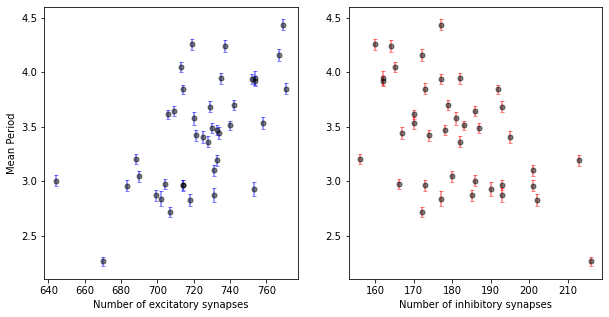

In [14]:
f = plt.figure(figsize=(10,5))
g = f.add_gridspec(1,2)

ax0 = f.add_subplot(g[0,0])
ax0.plot(lm_df['num_exc'], lm_df['ctrl_mean_amp'], '.', color = 'k', markersize = 10, alpha = 0.5)
ax0.set_xlabel('Number of excitatory synapses')
ax0.set_ylabel('Mean Amplitude')

ax1 = f.add_subplot(g[0,1])
ax1.plot(lm_df['num_inh'], lm_df['ctrl_mean_amp'], '.', color = 'k', markersize = 10, alpha = 0.5)
ax1.set_xlabel('Number of inhibitory synapses')

burst_stats = pd.read_csv('gnap_mod_burst_stats.csv')

for i in range(1,41):
    network_bursts = burst_stats.loc[burst_stats['run_seed'] == i]
    ax0.errorbar(lm_df.iloc[i-18]['num_exc'], lm_df.iloc[i-18]['ctrl_mean_amp'], yerr = network_bursts['Burst Amp'].sem(), 
                 capsize = 2, c='b',fmt = 'none', alpha = 0.5)
    ax1.errorbar(lm_df.iloc[i-18]['num_inh'], lm_df.iloc[i-18]['ctrl_mean_amp'], yerr = network_bursts['Burst Amp'].sem(), 
                 capsize = 2, c='r',fmt = 'none', alpha = 0.5)

### Regression analysis for mean burst amplitude

In [3]:
#lm1 = ols(formula="damgo_mean_period~I(num_e_e/num_exc)+num_exc+I(num_i_e/num_inh)+num_inh", data = lm_df).fit()
#lm1 = ols(formula="damgo_mean_amp~num_exc+num_inh", data = lm_df).fit()
lm1 = ols(formula = r'ctrl_mean_amp~num_exc+num_inh', data = lm_df).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ctrl_mean_amp   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     20.09
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           1.24e-06
Time:                        09:53:27   Log-Likelihood:                -13.888
No. Observations:                  40   AIC:                             33.78
Df Residuals:                      37   BIC:                             38.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0003      1.910     -0.524      0.604      -4.870       2.870
num_exc        0.0096      0.002      4.394      0.000       0.005       0.014
num_inh       -0.0139      0.004     -3.350      0.002      -0.022      -0.005
==============================================================================
Omnibus:                        1.363   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                0.994
Skew:                           0.009   Prob(JB):                        0.608
Kurtosis:                       2.228   Cond. No.                     2.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>


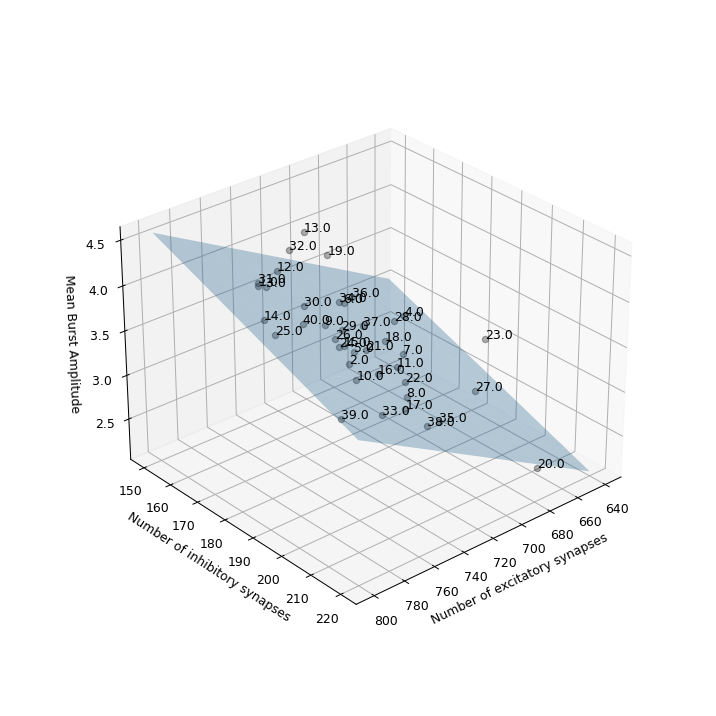

In [6]:
ax = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')
ax.plot(lm_df['num_exc'], lm_df['num_inh'], lm_df['ctrl_mean_amp'],'.', color = 'k', alpha = 0.3, markersize = 10)
#ax.errorbar(lm_df['num_exc'], lm_df['num_inh'], lm_df['mean_amp'], zerr = lm_df['mean_amp'].sem())

for idx,row in lm_df.iterrows():
    ax.text(row['num_exc'], row['num_inh'], row['ctrl_mean_amp'],'%s' % row['run_seed'],color='k')
#ax.errorbar(num_exc, num_inh, mean_amp, yerr = network_df['Burst Amp'].sem(), capsize = 4)

x_axis = np.linspace(640,800,10)
y_axis = np.linspace(150,220,10)
X,Y = np.meshgrid(x_axis,y_axis)
Z = lm1.params[0] + lm1.params[1]*X + lm1.params[2]*Y # given by regression results

ax.plot_surface(X,Y,Z, alpha = 0.3)
ax.set_xlabel('Number of excitatory synapses')
ax.set_ylabel('Number of inhibitory synapses')
ax.set_zlabel('Mean Burst Amplitude')
plt.show()
#plt.savefig('inh_exc_mean_amp.png')

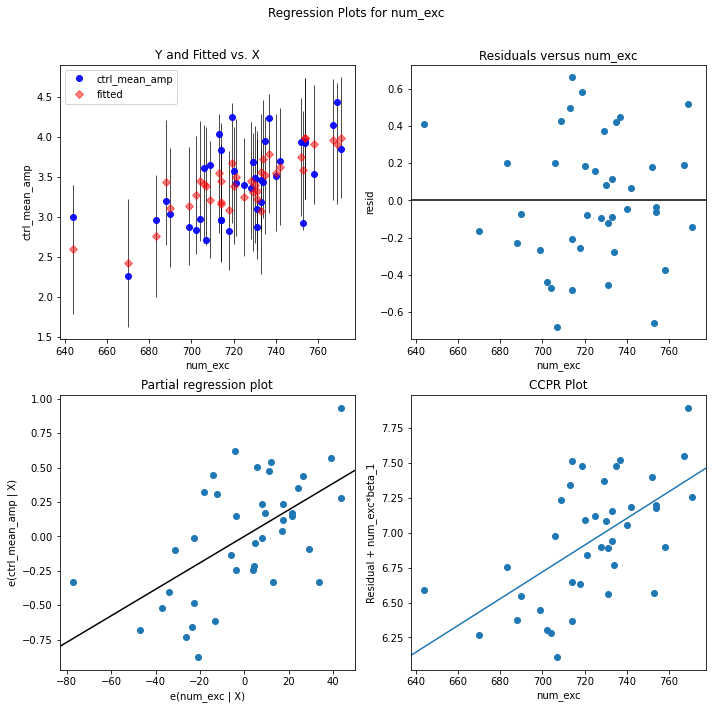

In [41]:
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_regress_exog(lm1, 'num_exc', fig=fig)

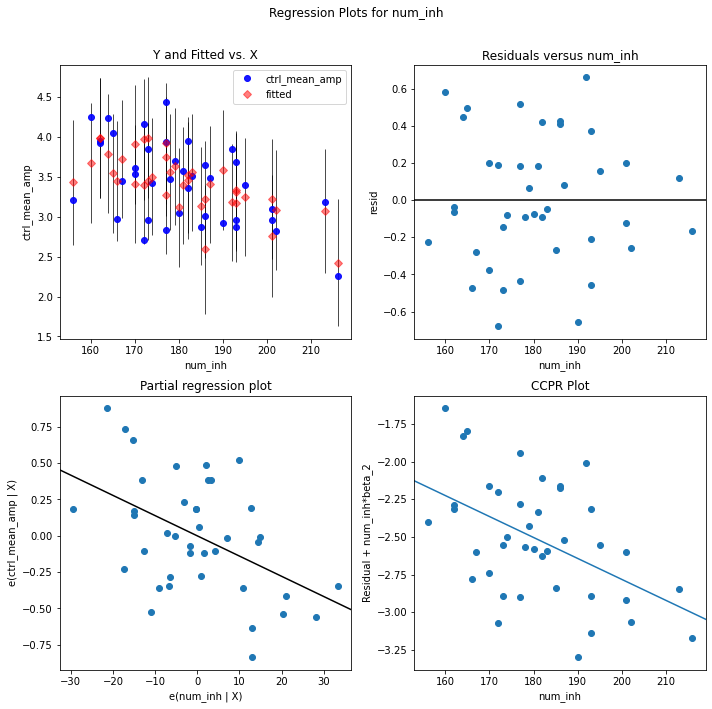

In [42]:
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_regress_exog(lm1, 'num_inh', fig=fig)

In [ ]:
lm1.f_test('num_exc = num_inh = 0')

### Regression Analysis for Period Irregularity

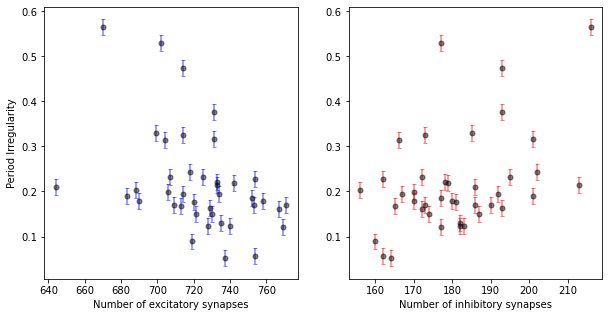

In [45]:
# f = plt.figure(figsize=(10,5))
# g = f.add_gridspec(1,2)

# ax0 = f.add_subplot(g[0,0])
# ax0.plot(lm_df['num_exc'], lm_df['ctrl_period_irs'], '.', color = 'k', markersize = 10)
# ax0.set_xlabel('Number of excitatory synapses')
# ax0.set_ylabel('Period Irregularity')

# ax1 = f.add_subplot(g[0,1])
# ax1.plot(lm_df['num_inh'], lm_df['ctrl_period_irs'], '.', color = 'k', markersize = 10)
# ax1.set_xlabel('Number of inhibitory synapses')

# for i in range(1,41):
#     network_df = burst_stats.loc[burst_stats['run_seed'] == i]
#     network_inh = network_df.iloc[0]['num_inh']
#     network_exc = network_df.iloc[0]['num_exc']
#     network_mean_amp = network_df['Burst Amp'].mean()

#     ax0.errorbar(lm_df.iloc[i-18]['num_exc'], lm_df.iloc[i-18]['ctrl_period_irs'], yerr = lm_df['ctrl_period_irs'].sem(), 
#                  capsize = 2, c='b',fmt = 'none', alpha = 0.5)
#     ax1.errorbar(lm_df.iloc[i-18]['num_inh'], lm_df.iloc[i-18]['ctrl_period_irs'], yerr = lm_df['ctrl_period_irs'].sem(), 
#                  capsize = 2, c='r',fmt = 'none', alpha = 0.5)
    
f = plt.figure(figsize=(10,5))
g = f.add_gridspec(1,2)

ax0 = f.add_subplot(g[0,0])
ax0.plot(lm_df['num_exc'], lm_df['ctrl_period_irs'], '.', color = 'k', markersize = 10, alpha = 0.5)
ax0.set_xlabel('Number of excitatory synapses')
ax0.set_ylabel('Period Irregularity')

ax1 = f.add_subplot(g[0,1])
ax1.plot(lm_df['num_inh'], lm_df['ctrl_period_irs'], '.', color = 'k', markersize = 10, alpha = 0.5)
ax1.set_xlabel('Number of inhibitory synapses')

burst_stats = pd.read_csv('gnap_mod_burst_stats.csv')

for i in range(1,41):
    network_bursts = burst_stats.loc[burst_stats['run_seed'] == i]
    ax0.errorbar(lm_df.iloc[i-18]['num_exc'], lm_df.iloc[i-18]['ctrl_period_irs'], yerr = lm_df['ctrl_period_irs'].sem(), 
                 capsize = 2, c='b',fmt = 'none', alpha = 0.5)
    ax1.errorbar(lm_df.iloc[i-18]['num_inh'], lm_df.iloc[i-18]['ctrl_period_irs'], yerr = lm_df['ctrl_period_irs'].sem(), 
                 capsize = 2, c='r',fmt = 'none', alpha = 0.5)

In [47]:
lm2 = ols(formula="ctrl_period_irs~num_exc+num_inh", data = lm_df).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ctrl_period_irs   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     7.199
Date:                Tue, 14 Sep 2021   Prob (F-statistic):            0.00229
Time:                        16:37:13   Log-Likelihood:                 37.825
No. Observations:                  40   AIC:                            -69.65
Df Residuals:                      37   BIC:                            -64.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7440      0.524      1.419      0.164      -0.318       1.806
num_exc       -0.0014      0.001     -2.322      0.026      -0.003      -0.000
num_inh        0.0027      0.001      2.339      0.025       0.000       0.005
==============================================================================
Omnibus:                        9.873   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.980
Skew:                           1.060   Prob(JB):                       0.0112
Kurtosis:                       3.946   Cond. No.                     2.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

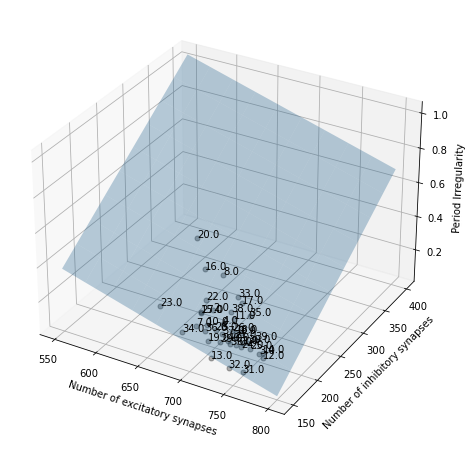

In [53]:
ax = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')
ax.plot(lm_df['num_exc'], lm_df['num_inh'], lm_df['ctrl_period_irs'],'.', color = 'k', alpha = 0.3, markersize = 10)

for idx,row in lm_df.iterrows():
    ax.text(row['num_exc'], row['num_inh'], row['ctrl_period_irs'],'%s' % row['run_seed'],color='k')

x_axis = np.linspace(550,800,10)
y_axis = np.linspace(150,400,10)
X,Y = np.meshgrid(x_axis,y_axis)
Z = lm2.params[0] + lm2.params[1]*X + lm2.params[2]*Y# given by regression results
ax.plot_surface(X,Y,Z, alpha = 0.3)

ax.set_xlabel('Number of excitatory synapses')
ax.set_ylabel('Number of inhibitory synapses')
ax.set_zlabel('Period Irregularity')
plt.show()
#plt.savefig('inh_exc_irs.png')

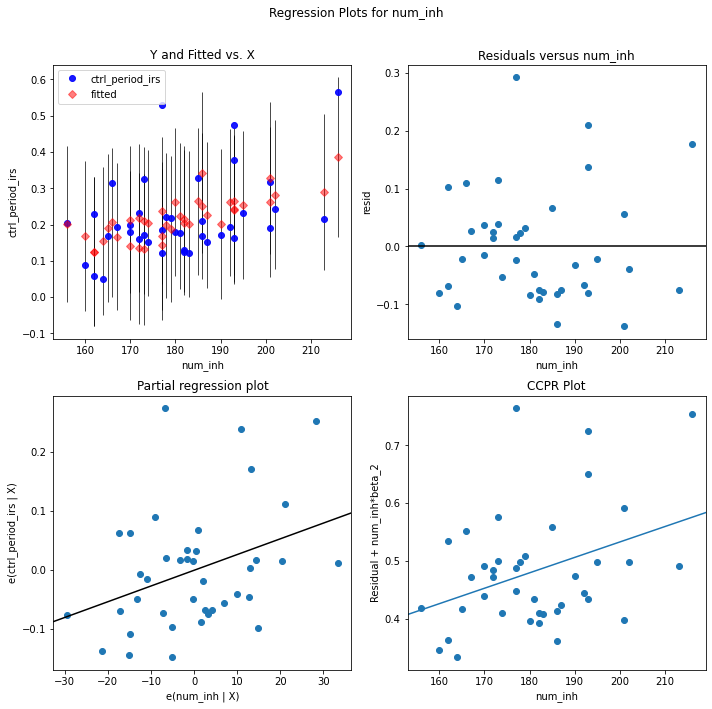

In [55]:
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_regress_exog(lm2, 'num_inh', fig=fig)

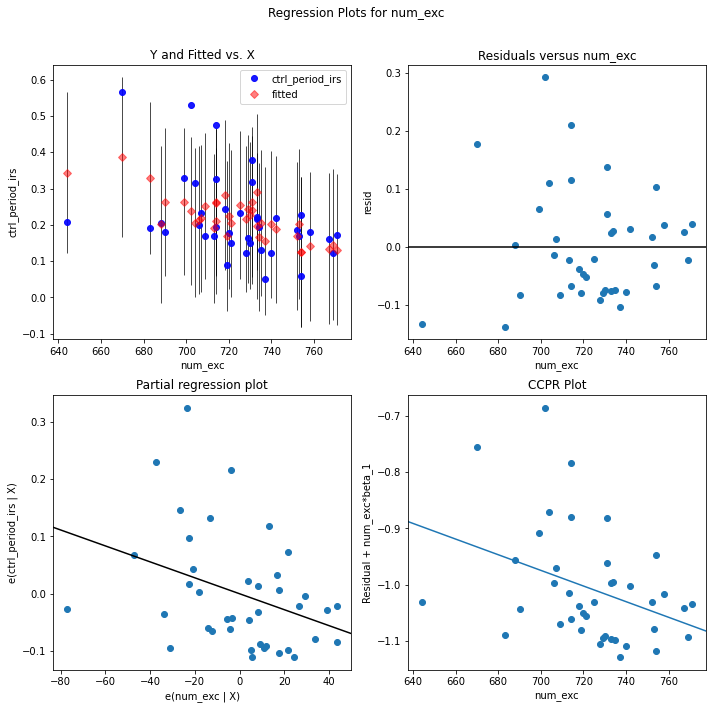

In [56]:
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_regress_exog(lm2, 'num_exc', fig=fig)

In [57]:
lm2.f_test('num_exc = num_inh = 0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[7.19888828]]), p=0.0022869767695178453, df_denom=37, df_num=2>

### Lasso and ridge regression 

In [59]:
features = ['num_e_e','num_e_i','num_i_e','num_i_i', 
            'num_ctrl_tonic_exc', 'num_ctrl_tonic_inh',
            'num_ctrl_burst_exc', 'num_ctrl_burst_inh',
            'num_ctrl_quiescent_exc', 'num_ctrl_quiescent_inh']

y = lm_df['ctrl_period_irs'].values
x = lm_df[features].values
X = preprocessing.StandardScaler().fit_transform(x)
    
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
model = Lasso().fit(X_train, y_train)
pred = model.predict(X_test)
print("MSE: " + str(mean_squared_error(y_test, pred)))

MSE: 0.030585980615273314


In [61]:
model.coef_

array([ 0.0126482 ,  0.00532527, -0.01523599, -0.01120096])

In [60]:
y = lm_df['ctrl_mean_amp']
X = lm_df[['num_e_e','num_e_i','num_i_e','num_i_i']]
    
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
pred = model.predict(X_test)
print("MSE: " + str(mean_squared_error(y_test, pred)))
print("R2: " + str(model.score(X_train,y_train)))

MSE: 0.1658303847373109
R2: 0.5146292973191184
